In [5]:
#Preamble. Standard packages for to load
import astropy
from astropy.table import Table, Column, MaskedColumn, vstack 
import numpy as np
import matplotlib.pyplot as plt
# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 
from astropy.io import fits
import astropy.io.ascii as ascii
from astropy.modeling import models, fitting
from numpy import ones
from numpy.linalg import lstsq
import pandas as pd
from scipy.stats import gaussian_kde
from scipy.stats import levy_stable
import matplotlib.patches as patches
from levy import levy
from future import builtins
from builtins import range

In [19]:
good_WD = Table.read('DA_with_LP_Mike_old.dat',format='ascii')
lambda_balmer = np.array([6563, 4861, 4341, 4102, 3970, 3889])

In [2]:
alpha, beta = 0.357, -0.675
m, v, s, k = levy_stable.stats(alpha,beta,moments='mvsk')

NotImplementedError: 

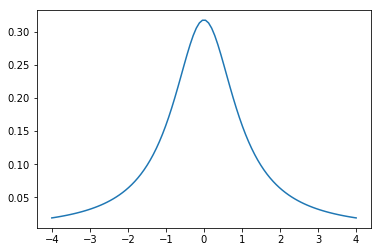

In [17]:
x = np.linspace(-4,4,100)
alpha = 1.0
beta = 0.0
plt.plot(x,levy(x,alpha,beta,mu=0))


In [49]:
def levy_model(x, alpha=1.0, mu=0.0, sigma=1.0, C=1.0):
    return C*levy(x,alpha,0.0,mu=mu,sigma=sigma)

In [68]:
models.Linear1D.intercept

Parameter('intercept', default=0)

In [20]:
def get_filename(plate,mjd,fiber,wd):
    try:
        plwd = wd[wd['Plate'] == plate]
        if len(plwd) == 0: raise Exception()
    except Exception:
        print 'No plate number'
        return ''
    try:
        mjwd = plwd[plwd['MJD'] == mjd]
        if len(mjwd) == 0: raise Exception()
    except Exception:
        print 'No mjd date'
        return ''
    try:
        fbwd = mjwd[mjwd['Fiber'] == fiber]
        if len(fbwd) == 0: raise Exception()
    except Exception:
        print 'No fiber number'
        return ''
    name = fbwd['file']
    return str(name[0])

In [21]:
def plot_spec(plate,mjd,fiber,wd):
    fits_spec = fits.open('../data/'+get_filename(plate,mjd,fiber,wd))
    wavelength = 10**fits_spec[1].data['loglam']
    flux = fits_spec[1].data['flux']
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    ax[0].plot(wavelength, flux)
    ax[1].plot(wavelength, flux)
    ax[1].set_xlim(3800, 4400)
    plt.show()

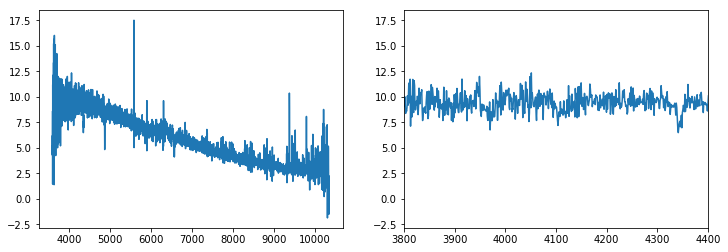

In [22]:
plot_spec(3760,55268,863,good_WD)

In [23]:
good_WD = good_WD.to_pandas()

count    8664.000000
mean       48.071012
std        32.661145
min     -1098.532890
25%        35.129055
50%        49.014959
75%        60.918698
max      1149.632532
Name: G0_0, dtype: float64

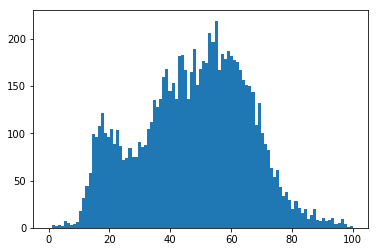

In [25]:
plt.hist(good_WD['G0_0'], bins = np.linspace(0,100,100))
good_WD['G0_0'].describe()

In [26]:
thresholds = [1.47, 3.21, 5.01, 7.46, 10.8, 13.99]

In [27]:
good_WD['Chi0_5'].describe(percentiles = [.80, .85, .90, .95])

count    8.660000e+03
mean     1.826237e+01
std      1.276539e+01
min      4.487922e-08
50%      1.502208e+01
80%      2.687299e+01
85%      3.018720e+01
90%      3.492822e+01
95%      4.229398e+01
max      1.677287e+02
Name: Chi0_5, dtype: float64

In [28]:
indexes = np.arange(0,6)
for i in indexes:
    good = good_WD['Chi0_%d' %i][good_WD['Chi0_%d' %i] < thresholds[i]]
    print good

38      1.327729e+00
357     1.031463e+00
597     1.364777e+00
625     1.436982e+00
776    -7.183668e-01
962     1.434106e+00
1261    9.296740e-01
1331    1.374025e+00
1355   -2.631948e+02
1438   -3.654941e+01
1458   -1.238669e+01
1470    1.368230e+00
1684    1.435633e+00
1999    2.463697e-07
2395   -3.949270e+00
2750   -1.703091e+01
3165    1.285761e+00
3280    1.156084e+00
3317    1.123143e+00
3524    1.128852e+00
3525    1.306682e+00
3702    1.094144e+00
3767    1.161429e+00
4075    1.233269e+00
4134    1.348000e+00
4349    1.216391e+00
4575    1.077243e+00
4709    1.248129e+00
5064    1.344425e-07
5151    5.349383e-07
            ...     
6311    1.391002e+00
6349    9.116826e-01
6351    8.934879e-01
6376    1.373599e+00
6407    1.222358e+00
6498    1.315710e+00
6887    1.254433e+00
6890    1.210708e+00
6897    1.444365e+00
6956    1.183123e+00
7045    1.347435e+00
7103    1.415295e+00
7237    1.359925e+00
7280    1.460236e+00
7305    1.044447e+00
7379    1.359925e+00
7462    1.375

In [29]:
def graph_window(lower_chi, upper_chi, lower_sn, upper_sn, Chi_name, good_WD):
    df = good_WD[Chi_name][(good_WD[Chi_name] > lower_chi) & (good_WD[Chi_name] < upper_chi) & (good_WD['S_N'] > lower_sn) & (good_WD['S_N'] < upper_sn)]
    return df

In [71]:
#This will find the spectra and plot the fitted Lorentzian
def plot_this(index, df, line):
    LevyObject = models.custom_model(levy_model)
    test = LevyObject()
    
    lambda_balmer = np.array([6563, 4861, 4341, 4102, 3970, 3889])
    window_size = np.array([120,90,60,60,50,40])
    
    G = df['G0_'+str(line)][index]
    C = df['C0_'+str(line)][index]
    X = df['X0_'+str(line)][index]
    M = df['M0_'+str(line)][index]
    Y = df['Y0_'+str(line)][index]
    
    directory = "../data/"
    filename = directory+'DA_high_SN_'+str(index).zfill(5)+'.fits'

    data = fits.getdata(filename, 1)
    
    all_flux = data['flux']
    all_lambda = 10 ** data['loglam']
    
    line_num = lambda_balmer[line]
    window = np.where(np.logical_and(all_lambda>= (line_num - window_size[line]), all_lambda<= (line_num + window_size[line])))[0]
    
    #sl = models.Lorentz1D(C, X, G)
    a = 1.
    s1 = test(a,X,G,C)
    linear = models.Linear1D(M,Y)
   
    fit = linear(all_lambda[window])-sl(all_lambda[window])
    
    plt.figure(figsize=(8,5))
    plt.plot(all_lambda[window], all_flux[window], 'ko')
    plt.plot(all_lambda[window], fit, label='Model')
    plt.xlabel('Lambda')
    plt.ylabel('Flux')
    plt.legend(loc=2)
#     plt.savefig('%f_%f.png' %(index,line))  

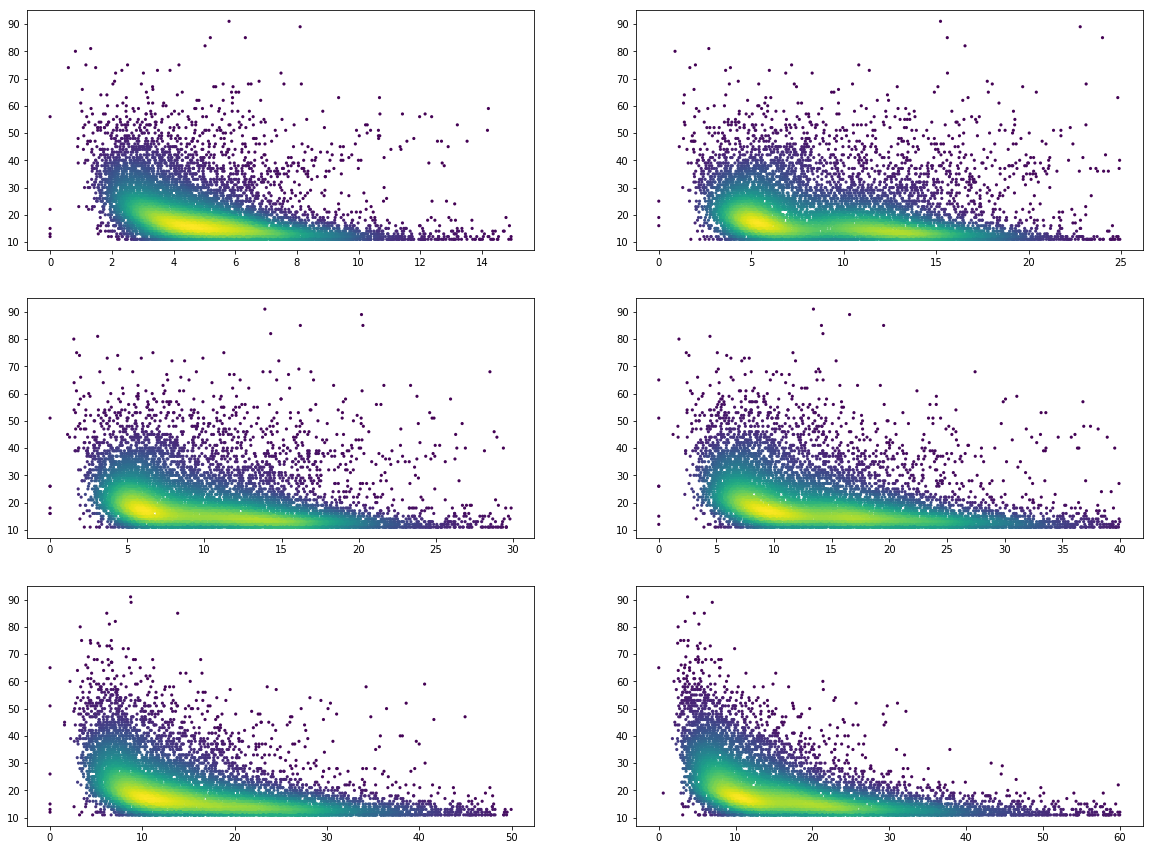

In [168]:
fig1 = plt.figure(figsize=(20,15))
ax1 = fig1.add_subplot(321)
x = good_WD['Chi0_0'][(good_WD['Chi0_0'] > 0) & (good_WD['Chi0_0'] < 15)] 
y = good_WD['S_N'][(good_WD['Chi0_0'] > 0) & (good_WD['Chi0_0'] < 15)]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax1.scatter(x, y, c = z, s=10, edgecolor = '');

# #In general, these are good but do not reach all the way down to the bottom
# ax1.add_patch(patches.Rectangle((4.25,15),0.25,3,fill=False,hatch='/',edgecolor='red'))

# #This group is actually better at reaching the bottom than the first group, despite lower signal to noise
# ax1.add_patch(patches.Rectangle((4.75,10),0.15,4,fill=False,hatch='/',edgecolor='red'))

# #Great data, models virtually always miss going all the way down in the core
# ax1.add_patch(patches.Rectangle((2.5,36),0.65,4,fill=False,hatch='/',edgecolor='red'))

# #Same - never reach bottom of core
# ax1.add_patch(patches.Rectangle((5.5,45),1,10,fill=False,hatch='/',edgecolor='red'))

# #Same
# ax1.add_patch(patches.Rectangle((2.80,20),0.4,2,fill=False,hatch='/',edgecolor='red'))

# #Not as great
# ax1.add_patch(patches.Rectangle((7.25,13),0.4,3,fill=False,hatch='/',edgecolor='red'))

# #Probably the worst
# ax1.add_patch(patches.Rectangle((10.25,10),1,15,fill=False,hatch='/',edgecolor='red'))

# ax1.add_patch(patches.Rectangle((0,50),4,30,fill=False,hatch='/',edgecolor='red'))


ax2 = fig1.add_subplot(322)
x = good_WD['Chi0_1'][(good_WD['Chi0_1'] > 0) & (good_WD['Chi0_1'] < 25)] 
y = good_WD['S_N'][(good_WD['Chi0_1'] > 0) & (good_WD['Chi0_1'] < 25)]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
plt.scatter(x, y, c = z, s=10, edgecolor = '');

# #In general, these are good. Reach farther down to bottom than in H-alpha
# ax2.add_patch(patches.Rectangle((4.8,15),0.3,3,fill=False,hatch='/',edgecolor='red'))

# #Reaching the bottom is the other big problem
# ax2.add_patch(patches.Rectangle((6,12),0.5,2,fill=False,hatch='/',edgecolor='red'))

# #Great data, models virtually always miss going all the way down in the core
# ax2.add_patch(patches.Rectangle((8.35,12),.3,6,fill=False,hatch='/',edgecolor='red'))

# #Same - never reach bottom of core
# ax2.add_patch(patches.Rectangle((13,13),.6,3,fill=False,hatch='/',edgecolor='red'))

# #Same
# ax1.add_patch(patches.Rectangle((2.80,20),0.4,2,fill=False,hatch='/',edgecolor='red'))

# #Not as great
# ax1.add_patch(patches.Rectangle((7.25,13),0.4,3,fill=False,hatch='/',edgecolor='red'))

# #Probably the worst
# ax1.add_patch(patches.Rectangle((10.25,10),1,15,fill=False,hatch='/',edgecolor='red'))

ax3 = fig1.add_subplot(323)
x = good_WD['Chi0_2'][(good_WD['Chi0_2'] > 0) & (good_WD['Chi0_2'] < 30)] 
y = good_WD['S_N'][(good_WD['Chi0_2'] > 0) & (good_WD['Chi0_2'] < 30)]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax3.scatter(x, y, c = z, s=10, edgecolor = '');

ax4 = fig1.add_subplot(324)
x = good_WD['Chi0_3'][(good_WD['Chi0_3'] > 0) & (good_WD['Chi0_3'] < 40)] 
y = good_WD['S_N'][(good_WD['Chi0_3'] > 0) & (good_WD['Chi0_3'] < 40)]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax4.scatter(x, y, c = z, s=10, edgecolor = '');

ax5 = fig1.add_subplot(325)
x = good_WD['Chi0_4'][(good_WD['Chi0_4'] > 0) & (good_WD['Chi0_4'] < 50)] 
y = good_WD['S_N'][(good_WD['Chi0_4'] > 0) & (good_WD['Chi0_4'] < 50)]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax5.scatter(x, y, c = z, s=10, edgecolor = '');

ax6 = fig1.add_subplot(326)
x = good_WD['Chi0_5'][(good_WD['Chi0_5'] > 0) & (good_WD['Chi0_5'] < 60)] 
y = good_WD['S_N'][(good_WD['Chi0_5'] > 0) & (good_WD['Chi0_5'] < 60)]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)
ax6.scatter(x, y, c = z, s=10, edgecolor = '');

In [33]:
selection = graph_window(5,15,80,100,'Chi0_4',good_WD)
to_plt = selection.index.values
print to_plt

[ 175 5874 5905 6498 7273 7290]


In [72]:
for j in to_plt:
    plot_this(j, good_WD, 0)
    break

TypeError: __call__() takes at most 3 arguments (5 given)

count    8664.000000
mean       26.451708
std        44.560277
min      -121.601703
25%        16.461205
50%        37.335731
75%        54.481776
max       237.329318
Name: GL0_0, dtype: float64

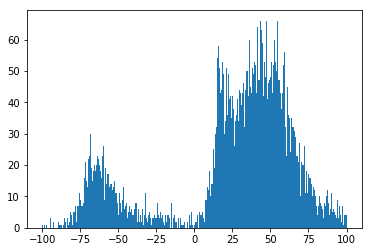

In [94]:
plt.hist(good_WD['GL0_0'],bins=np.linspace(-100,100,500))
good_WD['GL0_0'].describe()

(array([   0.,    0.,    0.,    0.,    0.,    1.,    0.,    1.,    0.,
           0.,    0.,    0.,    0.,    2.,    1.,    0.,    0.,    1.,
           0.,    0.,    1.,    0.,    0.,    3.,    0.,    0.,    0.,
           1.,    0.,    2.,    1.,    3.,    5.,    5.,    2.,    8.,
           7.,    7.,    7.,   11.,   11.,   15.,   16.,   17.,   27.,
          31.,   68.,   73.,   93.,  110.,  141.,  197.,  248.,  287.,
         368.,  440.,  522.,  543.,  649.,  627.,  635.,  570.,  581.,
         496.,  417.,  340.,  256.,  203.,  137.,  119.,   65.,   80.,
          45.,   29.,   25.,   13.,   18.,   13.,   13.,    6.,    6.,
           5.,    5.,    3.,    9.,    1.,    0.,    0.,    2.,    4.,
           0.,    0.,    2.,    0.,    1.,    1.,    0.,    0.,    1.]),
 array([-500.        , -489.8989899 , -479.7979798 , -469.6969697 ,
        -459.5959596 , -449.49494949, -439.39393939, -429.29292929,
        -419.19191919, -409.09090909, -398.98989899, -388.88888889,
        -378.

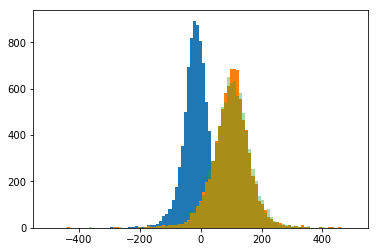

In [67]:
redshifts = Table.read('DA_with_LP_Mike.dat', format='ascii')
plt.hist(redshifts['z']*3*10**5, bins = np.linspace(-500,500,100));
plt.hist(((good_WD['X0_1']-lambda_balmer[1])/lambda_balmer[1])*3*10**5 , bins = np.linspace(-500,500,100));
plt.hist(((good_WD['X0_1']-lambda_balmer[1])/lambda_balmer[1])*3*10**5+good_WD['helio_rv'],bins = np.linspace(-500,500,100),alpha=0.4)
#redshifts['z'].describe()*3*10**5


In [15]:
((good_WD['X0_1']-lambda_balmer[1])/lambda_balmer[1]).describe()*3*10**5

count    2.599200e+09
mean     9.742985e+01
std      1.324571e+02
min     -7.057375e+03
25%      6.511105e+01
50%      1.021197e+02
75%      1.361019e+02
max      1.493277e+03
Name: X0_1, dtype: float64

0

In [134]:
#~good_WD['Mass'].isnull()
look = good_WD[~good_WD['Mass'].isnull()]
grav_red = np.sqrt(2953*look['Mass']*(10**look['logg']/200)/((3*10**8)**2))
grav_red.describe()*3*10**5

count    2.421900e+09
mean     3.279801e+01
std      1.822875e+01
min      2.460417e-01
25%      2.406421e+01
50%      2.942450e+01
75%      3.672071e+01
max      4.619029e+02
dtype: float64

(-300, 300)

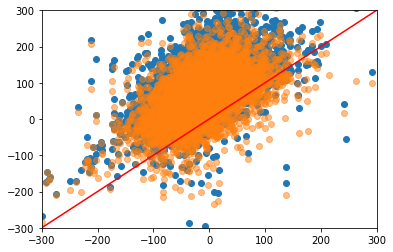

In [137]:
plt.scatter(redshifts['z']*3*10**5, ((good_WD['X0_1']-lambda_balmer[1])/lambda_balmer[1])*3*10**5)
plt.scatter(redshifts['z'][~good_WD['Mass'].isnull()]*3*10**5, ((good_WD['X0_1'][~good_WD['Mass'].isnull()]-lambda_balmer[1])/lambda_balmer[1])*3*10**5-(3*10**5)*grav_red,alpha=0.5)
plt.plot([-300,300],[-300,300],c='r')
#plt.plot([-300,300],[-300,300],c='g')
plt.xlim([-300,300])
plt.ylim([-300,300])

In [33]:
list(good_WD.columns.values)

['_RAJ2000',
 '_DEJ2000',
 'PMF',
 'SDSS',
 'S_N',
 'umag',
 'e_umag',
 'gmag',
 'e_gmag',
 'rmag',
 'e_rmag',
 'imag',
 'e_imag',
 'zmag',
 'e_zmag',
 'E_B-V_',
 'pm',
 'GLON',
 'GLAT',
 'SpType',
 'Teff',
 'e_Teff',
 'logg',
 'e_logg',
 'Teff_3D_',
 'e_Teff_3D_',
 'logg_3D_',
 'e_logg_3D_',
 'Mass',
 'e_Mass',
 'Com',
 'Sp',
 '_RA.icrs',
 '_DE.icrs',
 'Plate',
 'MJD',
 'Fiber',
 'RAJ2000',
 'DEJ2000',
 'SNg',
 'f_umag',
 'f_gmag',
 'f_rmag',
 'f_imag',
 'f_zmag',
 'f_pm',
 'pmPA',
 'Ag',
 'GMT',
 'Atype',
 'log_g_',
 'e_log_g_',
 'chi2',
 'm_Nsp',
 'Nsp',
 'q_Nsp',
 'Type',
 'WDcat',
 'DR7',
 'Sloan',
 'Simbad',
 'PMJ',
 '_RA',
 '_DE',
 'file',
 'C0_0',
 'C0_1',
 'C0_2',
 'C0_3',
 'C0_4',
 'C0_5',
 'G0_0',
 'G0_1',
 'G0_2',
 'G0_3',
 'G0_4',
 'G0_5',
 'X0_0',
 'X0_1',
 'X0_2',
 'X0_3',
 'X0_4',
 'X0_5',
 'Y0_0',
 'Y0_1',
 'Y0_2',
 'Y0_3',
 'Y0_4',
 'Y0_5',
 'M0_0',
 'M0_1',
 'M0_2',
 'M0_3',
 'M0_4',
 'M0_5',
 'Chi0_0',
 'Chi0_1',
 'Chi0_2',
 'Chi0_3',
 'Chi0_4',
 'Chi0_5']

In [44]:
sLength = len(good_WD['X0_0'])
good_WD['helio_rv'] = pd.Series(np.random.randn(sLength), index=good_WD.index)

In [54]:
def add_helio_rv_to_table(catalog):
    directory = "../data/DA_high_SN_"
    total = 0
    for ind in range(len(catalog['helio_rv'])):
        filename=directory+"%05d.fits" %ind
        header = fits.getheader(filename)
        good_WD['helio_rv'].iloc[ind] = header['HELIO_RV']
        total = total + 1
        if total%1000 == 0:  print(total)

In [55]:
add_helio_rv_to_table(good_WD)

//anaconda/envs/py27/lib/python2.7/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


1000
2000
3000
4000
5000
6000
7000
8000


In [59]:
good_WD['helio_rv'].describe()

count    8664.000000
mean        1.277829
std        16.068299
min       -30.253649
25%       -11.258894
50%         3.052526
75%        14.242254
max        30.339731
Name: helio_rv, dtype: float64